Train model on given data

## Trying Parallelism

In [ ]:
import multiprocessing

In [ ]:
import concurrent.futures
import time

start = time.perf_counter()


def do_something(seconds):
    print(f'Sleeping {seconds} second(s)...')
    time.sleep(seconds)
    return f'Done Sleeping...{seconds}'


with concurrent.futures.ProcessPoolExecutor() as executor:
    secs = [5, 4, 3, 2, 1]
    results = executor.map(do_something, secs)

    # for result in results:
    #     print(result)

finish = time.perf_counter()

print(f'Finished in {round(finish-start, 2)} second(s)')

In [ ]:


list_ = []

def train_model(contamination):
    # Train isolation forest model with given contamination parameter
    # Generate graphs and perform monitoring for this contamination parameter
    # This function encapsulates all the tasks you do for each contamination value
    
    # Example: Training code for isolation forest with contamination parameter
    # Your training code here

    # Example: Generating graphs
    # Your graph generation code here

    # Example: Monitoring
    # Your monitoring code here

    list_.append(contamination)
    return contamination


contamination_values = [0.1, 0.2, 0.3, 0.4]  # Example contamination values

# Create a pool of worker processes
pool = multiprocessing.Pool()

# Map the function to each contamination value in parallel
pool.map(train_model, contamination_values)

# Close the pool to free up resources
pool.close()
pool.join()


In [ ]:
list_

## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from kneed import KneeLocator
import random
import os
import json
from sklearn.neighbors import NearestNeighbors
import math

## Set up files

In [3]:
current_dir = os.getcwd()
current_dir

'd:\\E\\Study\\Projects\\basicml\\scripts\\training'

In [5]:
input_file=os.path.abspath(current_dir+"../../../data/training/data.csv")
training_logs_file=os.path.abspath(current_dir+"../../../data/training/training_logs.json")
training_data_path=os.path.abspath(current_dir+"../../../data/training/")
plots_path=os.path.abspath(current_dir+"../../../plots/")
pickle_model = os.path.abspath(current_dir+"./../../resources/model.pkl")

## Generate Data and Save

<class 'numpy.ndarray'>


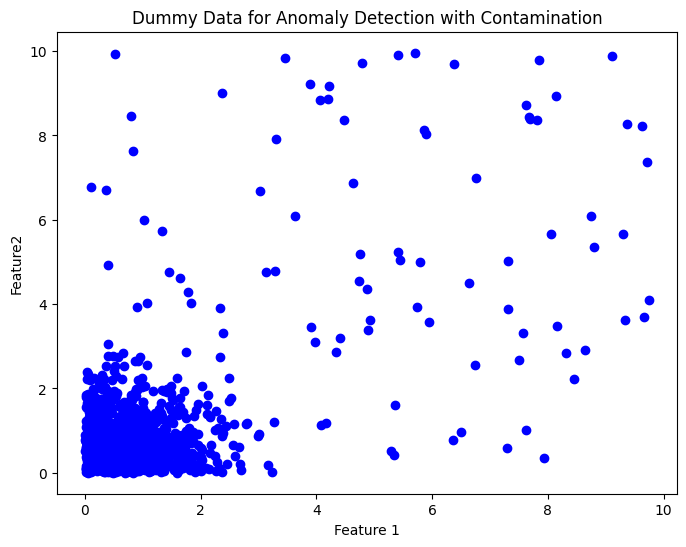

In [6]:
def generate_dummy_data(n_samples, contamination):
    # Generate normal data
    np.random.seed(0)
    normal_data, _ = make_blobs(n_samples=int(n_samples * (1 - contamination)), centers=1, cluster_std=1, center_box=(0,0))
    print(type(normal_data))
    normal_data = [abs(point) for point in normal_data]
    # Generate anomalies (contamination)
    anomaly_data= np.random.uniform(low=0, high=10, size=(int(n_samples * contamination), 2))

    # Combine normal and anomaly data
    data = np.vstack([normal_data, anomaly_data])

    # Shuffle the data
    np.random.shuffle(data)
    
    return data

# Example usage
data = generate_dummy_data(n_samples=1000, contamination=0.1)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c='b')
plt.title('Dummy Data for Anomaly Detection with Contamination')
plt.xlabel('Feature 1')
plt.ylabel('Feature2')
plt.show()

In [7]:
df = pd.DataFrame(data, columns=['column1','column2'])
df.to_csv(input_file, index=False)

## Read data

In [36]:
print(input_file)
df = pd.read_csv(input_file)
print(df.shape)
print(df.columns)
df.head()

d:\E\Study\Projects\basicml\data\training\data.csv
(1000, 2)
Index(['column1', 'column2'], dtype='object')


,column1,column2
0,0.161374,1.794449
1,1.613898,0.212740
2,0.790523,0.907300
3,1.840657,4.027072
4,1.502397,1.777667


In [37]:
Feature1 = 'Amount of extra heat'
Feature2 = 'Amount of extra cold'

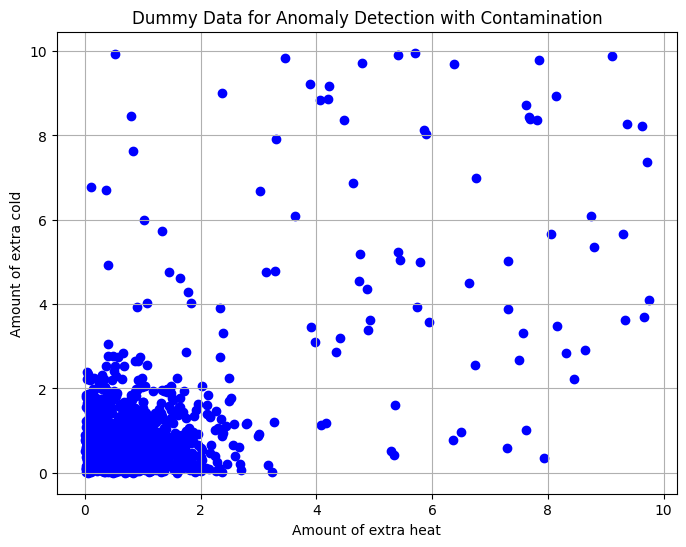

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c='b')
plt.title('Dummy Data for Anomaly Detection with Contamination')
plt.grid()
plt.xlabel('{}'.format(Feature1))
plt.ylabel('{}'.format(Feature2))
plt.show()

## Apply Business Rules

In [39]:
def business_rule_anomaly(row,feature1_bounds,feature2_bounds):
    f1 = row['column1']
    f2 = row['column2']

    if(f1>feature1_bounds[1] or f1<feature1_bounds[0] or f2>feature2_bounds[1] or f2<feature2_bounds[0]):
        return -1
    else:
        return 1
    
def business_rule_nonanomaly(row,feature1_bounds,feature2_bounds):
    f1 = row['column1']
    f2 = row['column2']

    if(f1<=feature1_bounds[1] and f1>=feature1_bounds[0] and f2<=feature2_bounds[1] and f2>=feature2_bounds[0]):
        return -1
    else:
        return 1

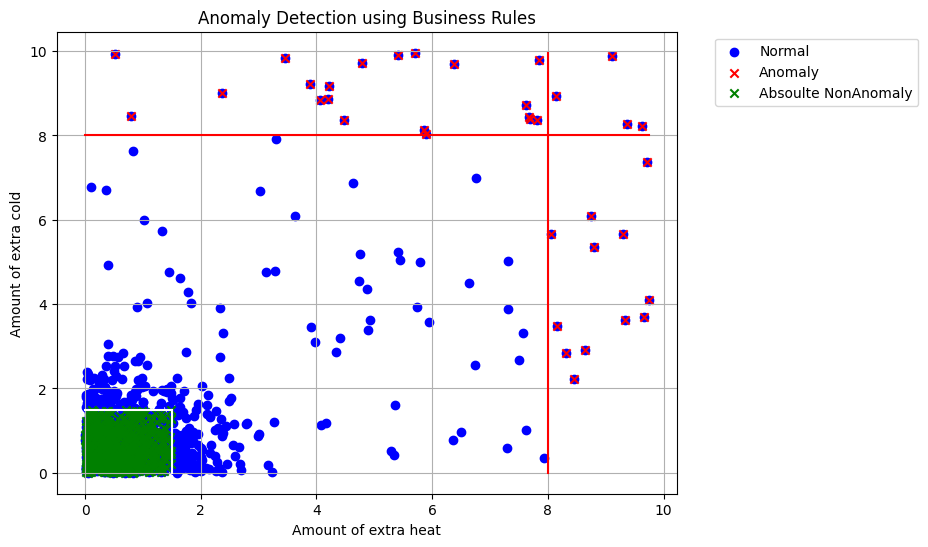

In [40]:
feature1_max=df['column1'].max()
feature1_min=df['column1'].min()
feature2_max=df['column2'].max()
feature2_min=df['column2'].min()

feature1_anomaly_bounds=[0,8]
feature2_anomaly_bounds=[0,8]
feature1_nonanomaly_bounds=[0,1.5]
feature2_nonanomaly_bounds=[0,1.5]

df['business_rule_anomaly'] = df.apply(business_rule_anomaly,axis=1,feature1_bounds=feature1_anomaly_bounds, feature2_bounds=feature2_anomaly_bounds)
df['business_rule_nonanomaly'] = df.apply(business_rule_nonanomaly,axis=1,feature1_bounds=feature1_nonanomaly_bounds, feature2_bounds=feature2_nonanomaly_bounds)

anomaly_indices = np.where(df['business_rule_anomaly'] == -1)[0]
nonanomaly_indices = np.where(df['business_rule_nonanomaly'] == -1)[0]
plt.figure(figsize=(8, 6))
# plot all points
plt.scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
# plot anomalies
plt.scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
# plot nonanomalies
plt.scatter(df.iloc[nonanomaly_indices, 0], df.iloc[nonanomaly_indices, 1], c='g', marker='x', label='Absoulte NonAnomaly')

# plot anomaly bounds
plt.plot([feature1_min,feature1_max],[feature2_anomaly_bounds[1],feature2_anomaly_bounds[1]],color='red')
plt.plot([feature1_anomaly_bounds[1],feature1_anomaly_bounds[1]],[feature2_min,feature2_max],color='red')

# plot nonanomaly bounds
plt.plot([feature1_nonanomaly_bounds[1],feature1_nonanomaly_bounds[1]],[feature1_min,feature2_nonanomaly_bounds[1]],color='white')
plt.plot([feature2_min,feature1_nonanomaly_bounds[1]],[feature2_nonanomaly_bounds[1],feature2_nonanomaly_bounds[1]],color='white')

plt.title('Anomaly Detection using Business Rules')
plt.xlabel('{}'.format(Feature1))
plt.ylabel('{}'.format(Feature2))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

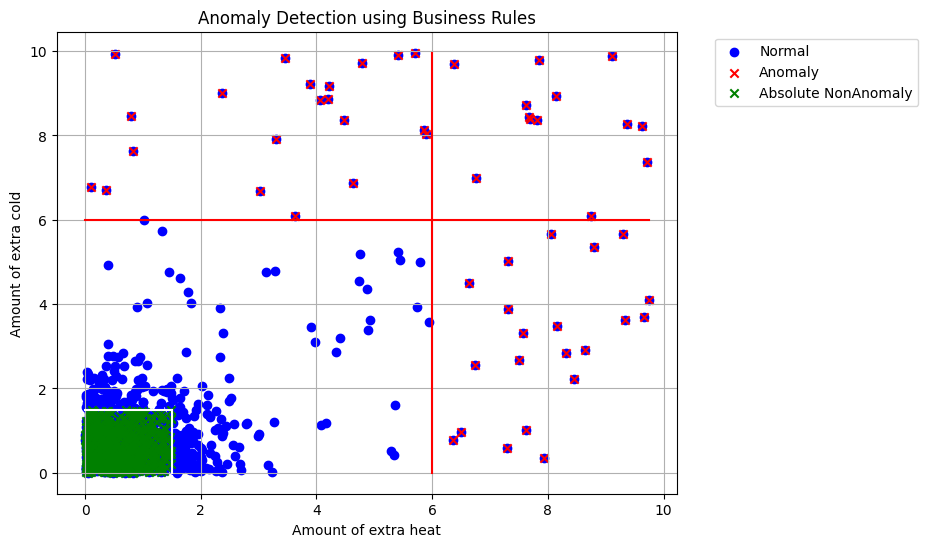

In [41]:
feature1_max=df['column1'].max()
feature1_min=df['column1'].min()
feature2_max=df['column2'].max()
feature2_min=df['column2'].min()

feature1_anomaly_bounds=[0,6]
feature2_anomaly_bounds=[0,6]
feature1_nonanomaly_bounds=[0,1.5]
feature2_nonanomaly_bounds=[0,1.5]

df['business_rule_anomaly'] = df.apply(business_rule_anomaly,axis=1,feature1_bounds=feature1_anomaly_bounds, feature2_bounds=feature2_anomaly_bounds)
df['business_rule_nonanomaly'] = df.apply(business_rule_nonanomaly,axis=1,feature1_bounds=feature1_nonanomaly_bounds, feature2_bounds=feature2_nonanomaly_bounds)

anomaly_indices = np.where(df['business_rule_anomaly'] == -1)[0]
nonanomaly_indices = np.where(df['business_rule_nonanomaly'] == -1)[0]
plt.figure(figsize=(8, 6))
# plot all points
plt.scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
# plot anomalies
plt.scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
# plot nonanomalies
plt.scatter(df.iloc[nonanomaly_indices, 0], df.iloc[nonanomaly_indices, 1], c='g', marker='x', label='Absolute NonAnomaly')

# plot anomaly bounds
plt.plot([feature1_min,feature1_max],[feature2_anomaly_bounds[1],feature2_anomaly_bounds[1]],color='red')
plt.plot([feature1_anomaly_bounds[1],feature1_anomaly_bounds[1]],[feature2_min,feature2_max],color='red')

# plot nonanomaly bounds
plt.plot([feature1_nonanomaly_bounds[1],feature1_nonanomaly_bounds[1]],[feature1_min,feature2_nonanomaly_bounds[1]],color='white')
plt.plot([feature2_min,feature1_nonanomaly_bounds[1]],[feature2_nonanomaly_bounds[1],feature2_nonanomaly_bounds[1]],color='white')

plt.title('Anomaly Detection using Business Rules')
plt.xlabel('{}'.format(Feature1))
plt.ylabel('{}'.format(Feature2))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

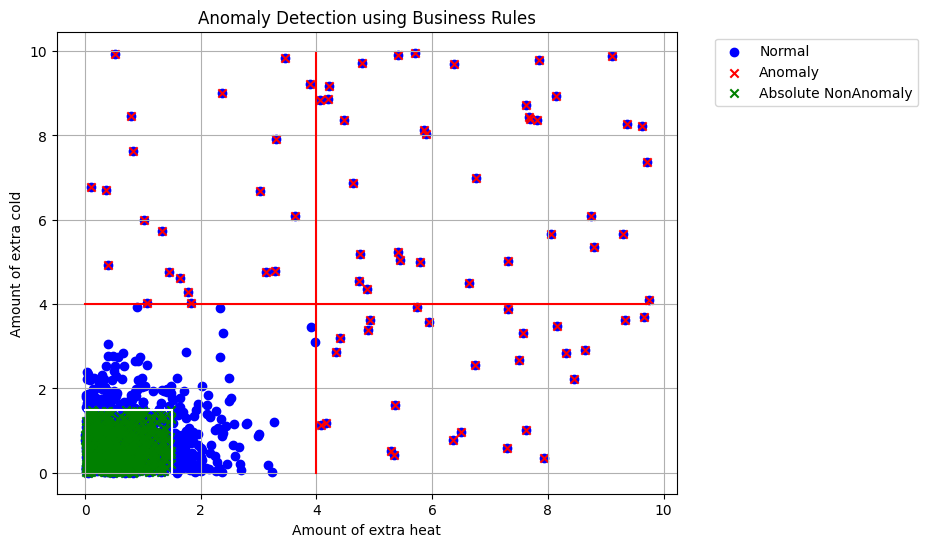

In [42]:
feature1_max=df['column1'].max()
feature1_min=df['column1'].min()
feature2_max=df['column2'].max()
feature2_min=df['column2'].min()

feature1_anomaly_bounds=[0,4]
feature2_anomaly_bounds=[0,4]
feature1_nonanomaly_bounds=[0,1.5]
feature2_nonanomaly_bounds=[0,1.5]

df['business_rule_anomaly'] = df.apply(business_rule_anomaly,axis=1,feature1_bounds=feature1_anomaly_bounds, feature2_bounds=feature2_anomaly_bounds)
df['business_rule_nonanomaly'] = df.apply(business_rule_nonanomaly,axis=1,feature1_bounds=feature1_nonanomaly_bounds, feature2_bounds=feature2_nonanomaly_bounds)

anomaly_indices = np.where(df['business_rule_anomaly'] == -1)[0]
nonanomaly_indices = np.where(df['business_rule_nonanomaly'] == -1)[0]
plt.figure(figsize=(8, 6))
# plot all points
plt.scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
# plot anomalies
plt.scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
# plot nonanomalies
plt.scatter(df.iloc[nonanomaly_indices, 0], df.iloc[nonanomaly_indices, 1], c='g', marker='x', label='Absolute NonAnomaly')

# plot anomaly bounds
plt.plot([feature1_min,feature1_max],[feature2_anomaly_bounds[1],feature2_anomaly_bounds[1]],color='red')
plt.plot([feature1_anomaly_bounds[1],feature1_anomaly_bounds[1]],[feature2_min,feature2_max],color='red')

# plot nonanomaly bounds
plt.plot([feature1_nonanomaly_bounds[1],feature1_nonanomaly_bounds[1]],[feature1_min,feature2_nonanomaly_bounds[1]],color='white')
plt.plot([feature2_min,feature1_nonanomaly_bounds[1]],[feature2_nonanomaly_bounds[1],feature2_nonanomaly_bounds[1]],color='white')

plt.title('Anomaly Detection using Business Rules')
plt.xlabel('{}'.format(Feature1))
plt.ylabel('{}'.format(Feature2))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

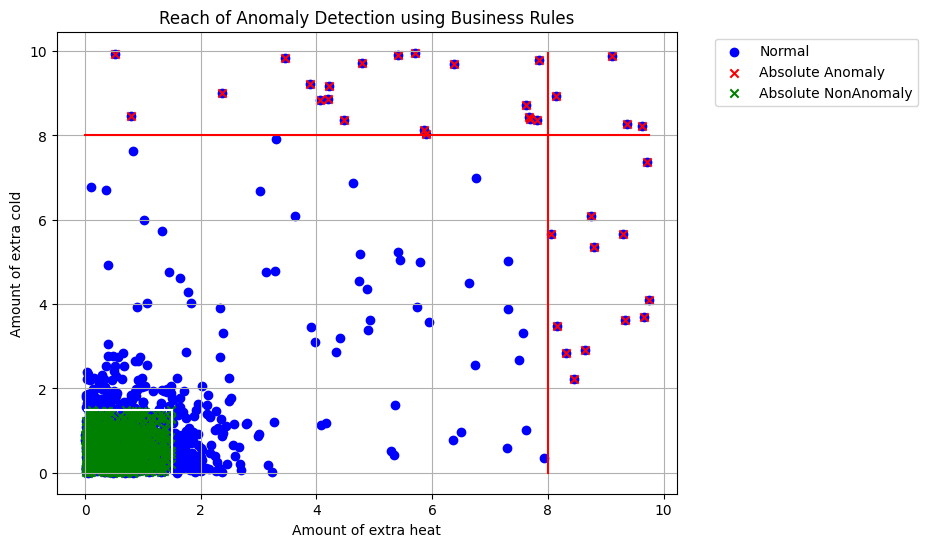

In [43]:
# Reach of Business Rules

feature1_max=df['column1'].max()
feature1_min=df['column1'].min()
feature2_max=df['column2'].max()
feature2_min=df['column2'].min()

feature1_anomaly_bounds=[0,8]
feature2_anomaly_bounds=[0,8]
feature1_nonanomaly_bounds=[0,1.5]
feature2_nonanomaly_bounds=[0,1.5]

df['business_rule_anomaly'] = df.apply(business_rule_anomaly,axis=1,feature1_bounds=feature1_anomaly_bounds, feature2_bounds=feature2_anomaly_bounds)
df['business_rule_nonanomaly'] = df.apply(business_rule_nonanomaly,axis=1,feature1_bounds=feature1_nonanomaly_bounds, feature2_bounds=feature2_nonanomaly_bounds)

anomaly_indices = np.where(df['business_rule_anomaly'] == -1)[0]
nonanomaly_indices = np.where(df['business_rule_nonanomaly'] == -1)[0]
plt.figure(figsize=(8, 6))
# plot all points
plt.scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
# plot anomalies
plt.scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Absolute Anomaly')
# plot nonanomalies
plt.scatter(df.iloc[nonanomaly_indices, 0], df.iloc[nonanomaly_indices, 1], c='g', marker='x', label='Absolute NonAnomaly')

# plot anomaly bounds
plt.plot([feature1_min,feature1_max],[feature2_anomaly_bounds[1],feature2_anomaly_bounds[1]],color='red')
plt.plot([feature1_anomaly_bounds[1],feature1_anomaly_bounds[1]],[feature2_min,feature2_max],color='red')

# plot nonanomaly bounds
plt.plot([feature1_nonanomaly_bounds[1],feature1_nonanomaly_bounds[1]],[feature1_min,feature2_nonanomaly_bounds[1]],color='white')
plt.plot([feature2_min,feature1_nonanomaly_bounds[1]],[feature2_nonanomaly_bounds[1],feature2_nonanomaly_bounds[1]],color='white')

plt.title('Reach of Anomaly Detection using Business Rules')
plt.xlabel('{}'.format(Feature1))
plt.ylabel('{}'.format(Feature2))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()


## Feature Engineering

## Make Data Ready for ML


In [44]:
df_with_business_results = df.copy()
df = df.drop(df.loc[df['business_rule_anomaly']==-1].index,axis=0)
print(df.shape)
df = df.reset_index(drop=True)
df = df.drop(columns=['business_rule_anomaly','business_rule_nonanomaly'])

(964, 4)


## Hyperparameter tuning

Preparation

e^-(X^2) is a function which maps 

0 to 1

-inf to 0

+inf to 0

ALso, find out derivative of sigmoid function.

It also represents above function.

In [45]:
# # understanding nearest neighbours distances
# samples = [[0, 0],[1,1],[2,2]]
# neigh = NearestNeighbors(n_neighbors=3)
# neigh.fit(samples)
# print(neigh.kneighbors([[0,2],[0,0]])[0])
# np.min(neigh.kneighbors([[0,2],[0,0]])[0],axis=1)

In [46]:
def calculate_avg_anomaly_score(model, df_anomaly):
    anomaly_scores = model.decision_function(df_anomaly.values)
    avg_anomaly_score = np.mean(anomaly_scores)
    return avg_anomaly_score

def calculate_separation_distances(df_to_fit, df_to_calculate):
    n_neighbors = 3
    result=0 if (len(df_to_fit)==0 or len(df_to_calculate)==0) else 1

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree',n_jobs=-1).fit(df_to_fit.values)
    nbrs.kneighbors(df_to_calculate.values)
    distances = nbrs.kneighbors(df_to_calculate.values)[0]
    required_distances = np.min(distances, axis=1)
    result = np.min(required_distances)
    return result

actual

First check if the range of parameters you are setting is right

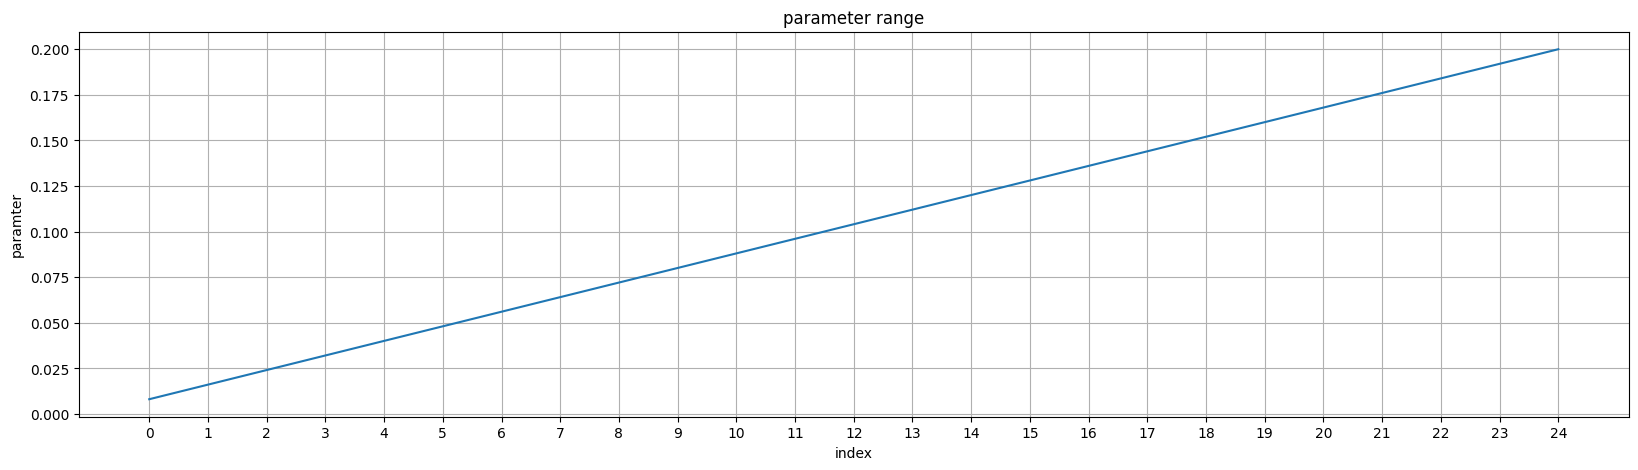

In [47]:
#iterations = 5
main_start_point=0.0001
main_end_point=0.2

main_intervals=5
points_in_each_interval=5
step=(main_end_point-main_start_point)/main_intervals
small_step=step/points_in_each_interval
knee_points=[]
training_logs = {}

range_=[]

start_point=main_start_point
for _ in range(main_intervals):
    for _ in range(points_in_each_interval):
        #range_.append(random.uniform(start_point,start_point+step))
        range_.append(start_point+small_step)
        start_point=start_point+small_step

range_.sort()
plt.figure(figsize=(20,5))
plt.plot(range(len(range_)),range_)
plt.xlabel("index")
plt.ylabel("paramter")
plt.title("parameter range")
plt.xticks(range(len(range_)))
plt.grid()
plt.savefig(plots_path+"/training-parameter_generation.png")
plt.show()
plt.close()

random_number:  1
Contaminantion:  0.008095999999999999


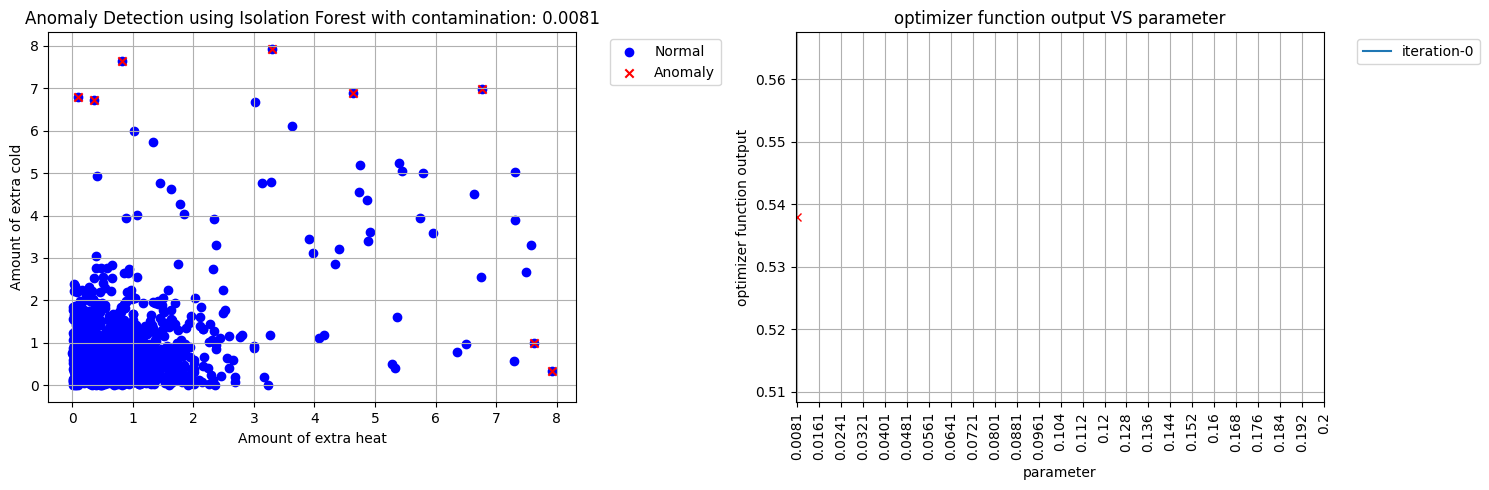

Contaminantion:  0.016092


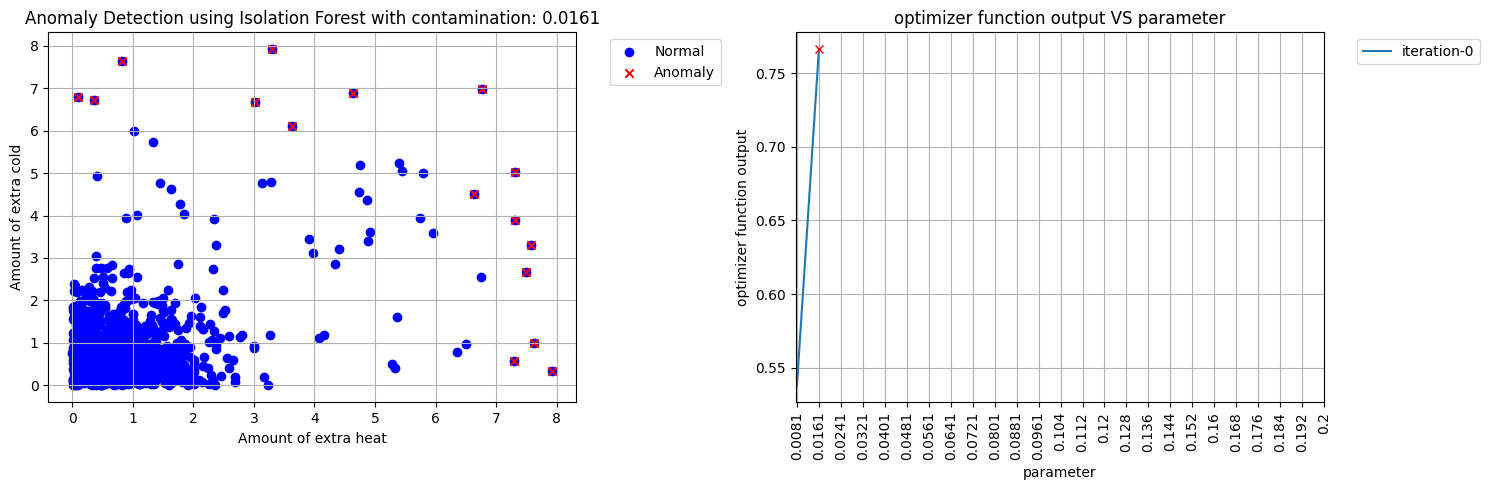

Contaminantion:  0.024088


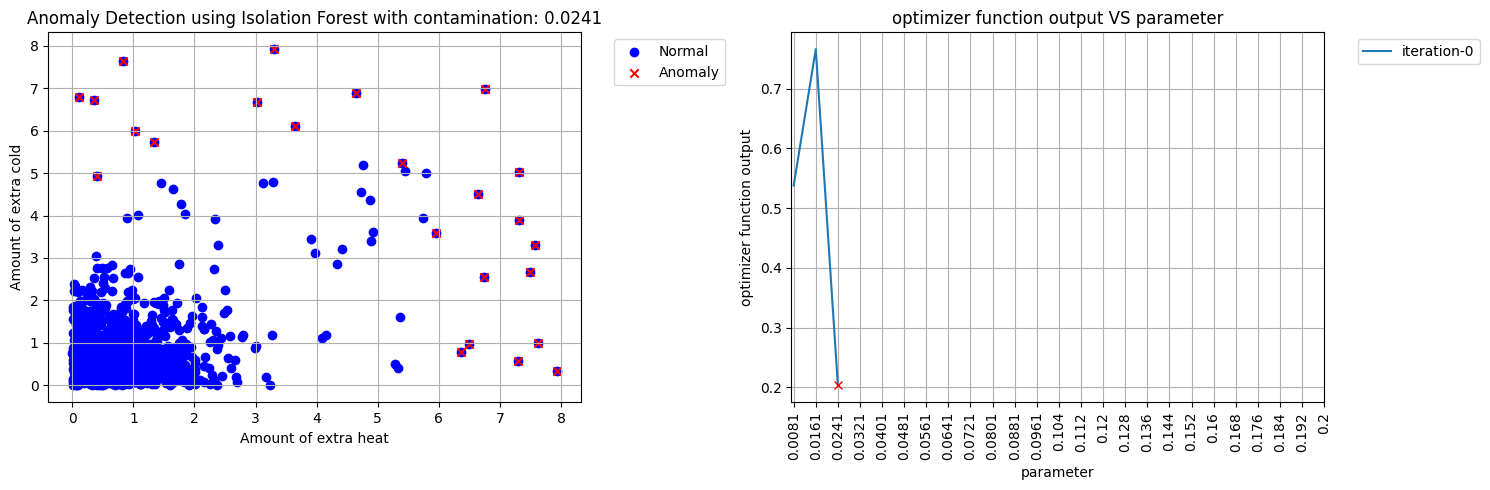

Contaminantion:  0.032084


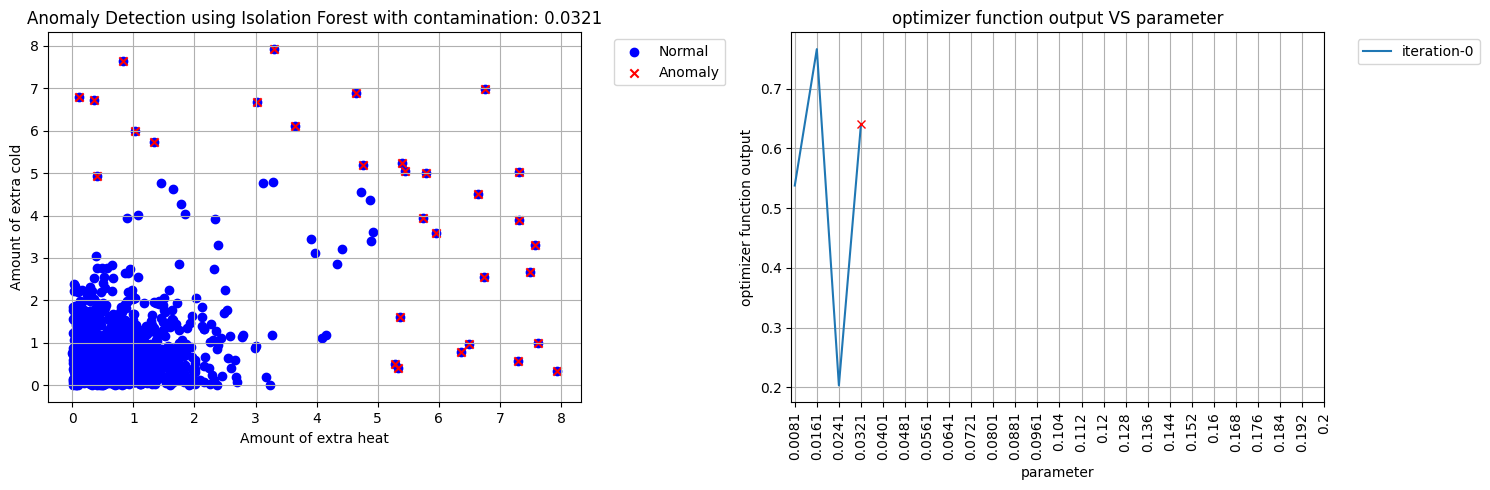

Contaminantion:  0.040080000000000005


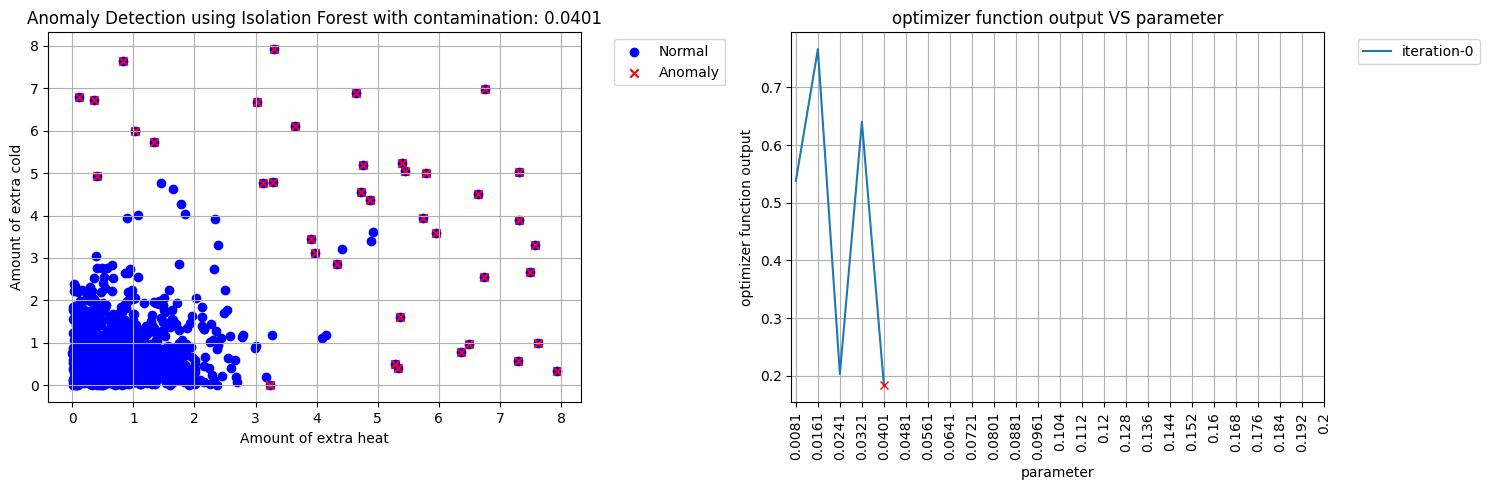

Contaminantion:  0.04807600000000001


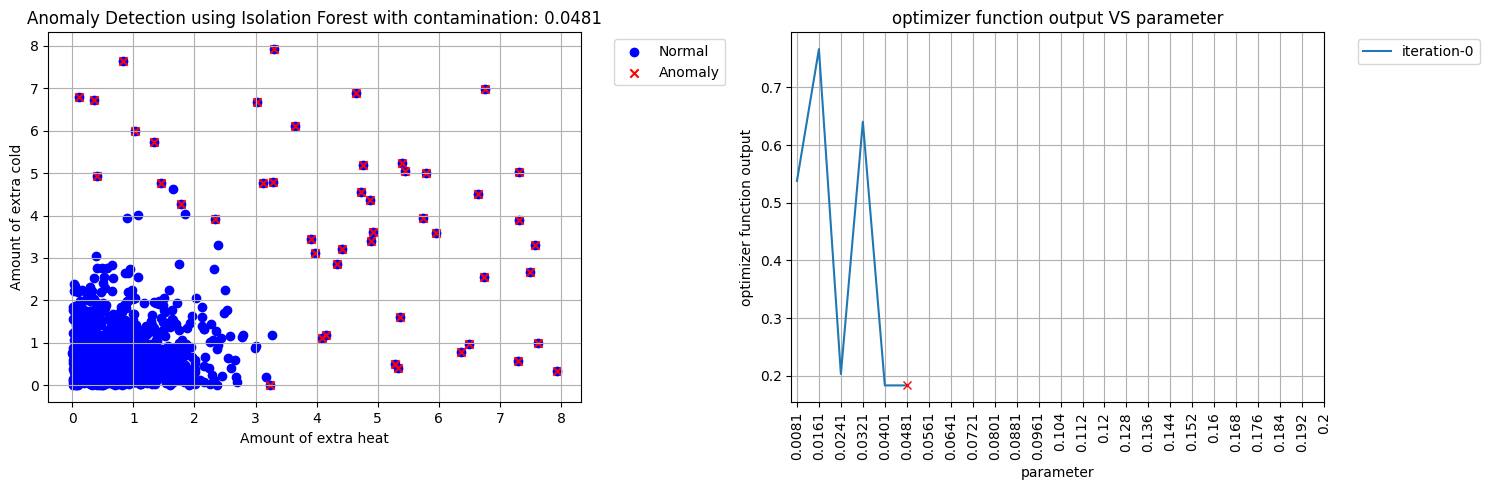

Contaminantion:  0.05607200000000001


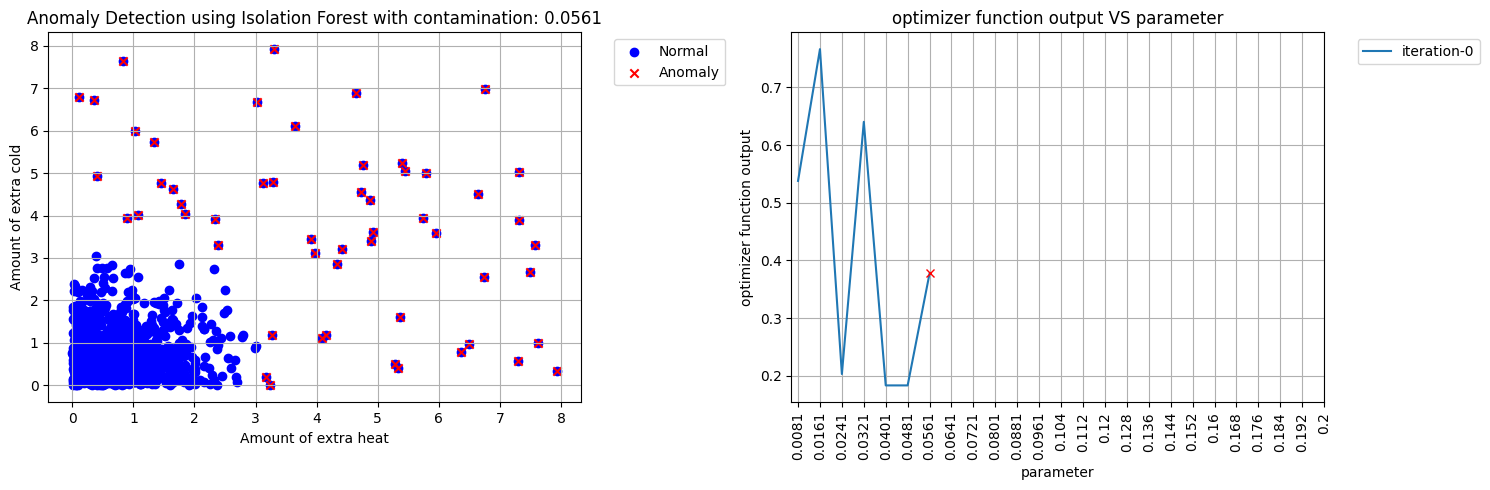

Contaminantion:  0.06406800000000001


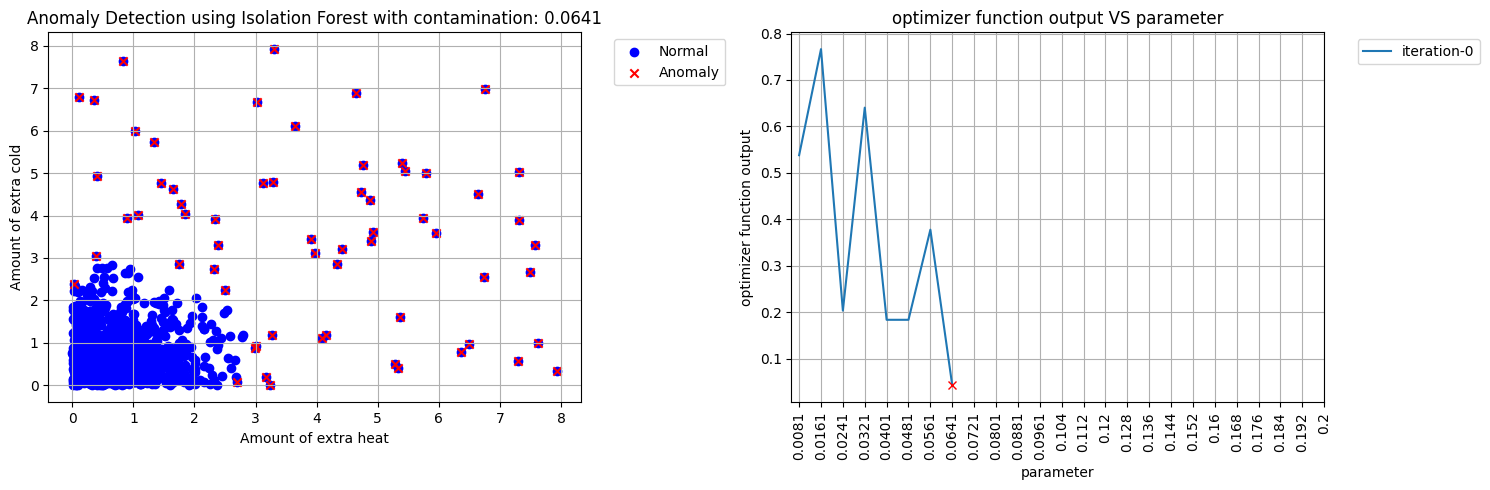

Contaminantion:  0.07206400000000002


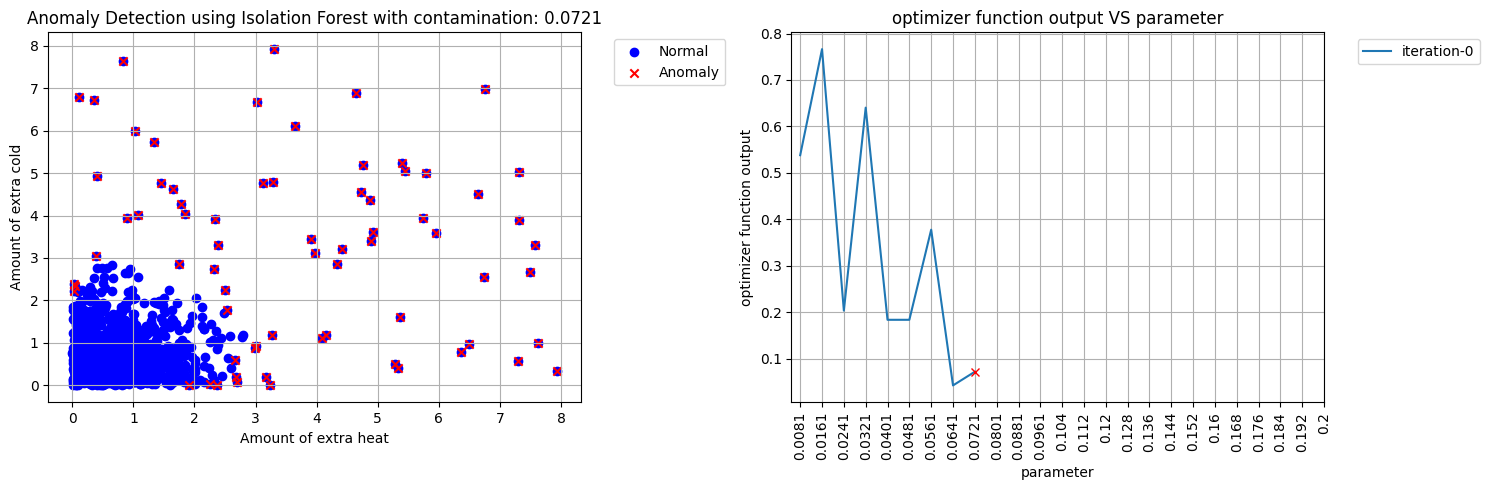

Contaminantion:  0.08006000000000002


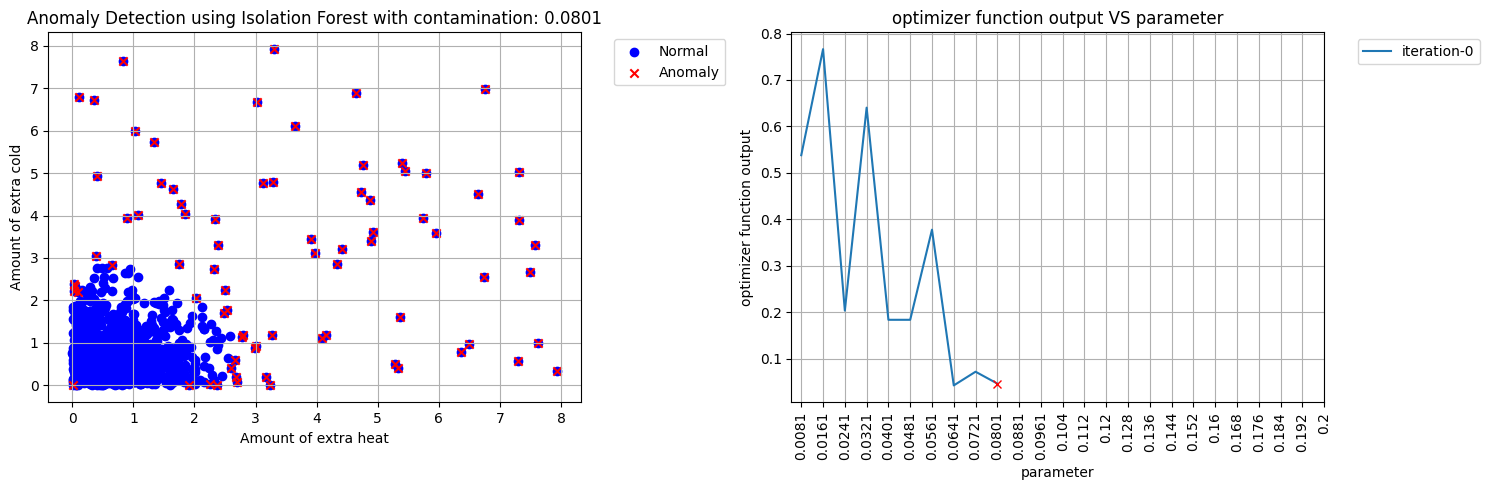

Contaminantion:  0.08805600000000002


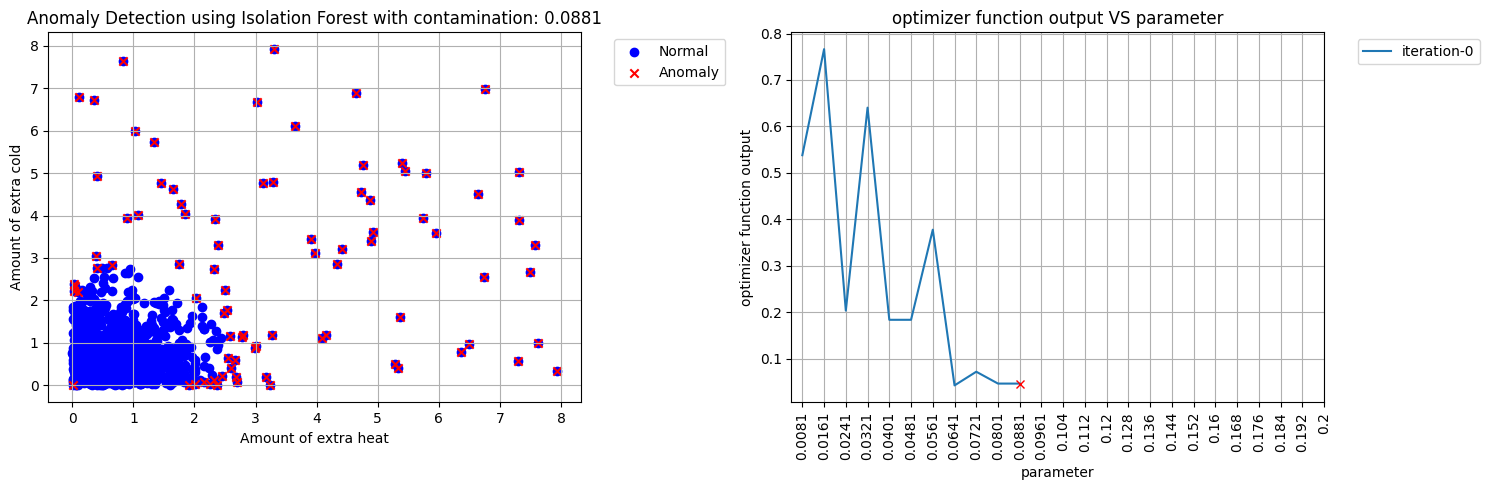

Contaminantion:  0.09605200000000003


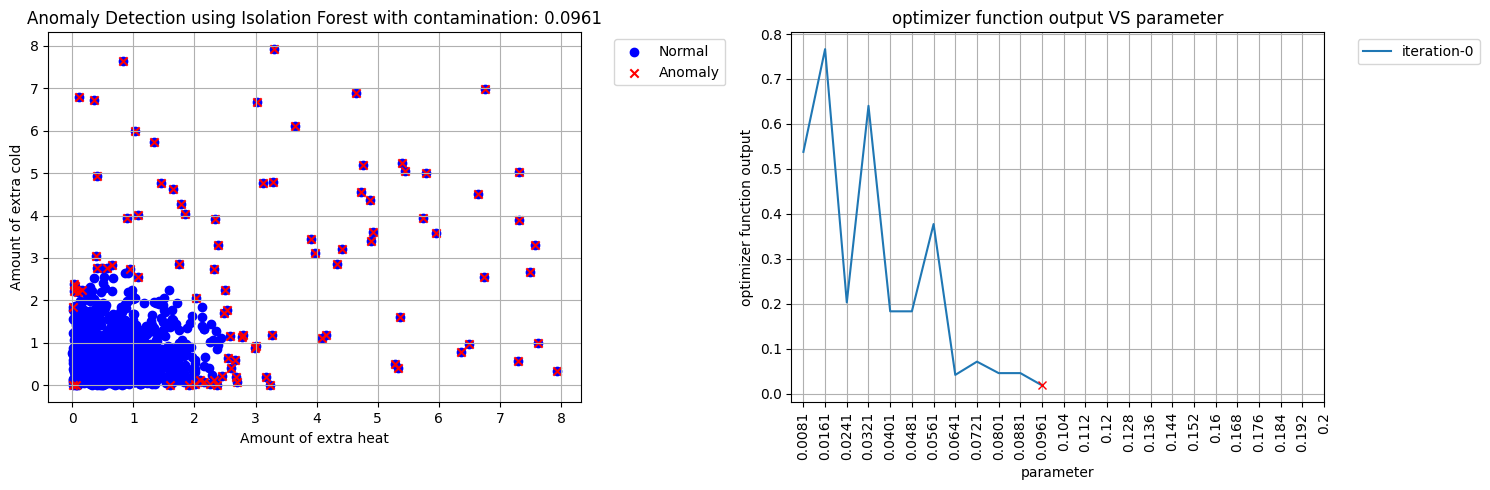

Contaminantion:  0.10404800000000003


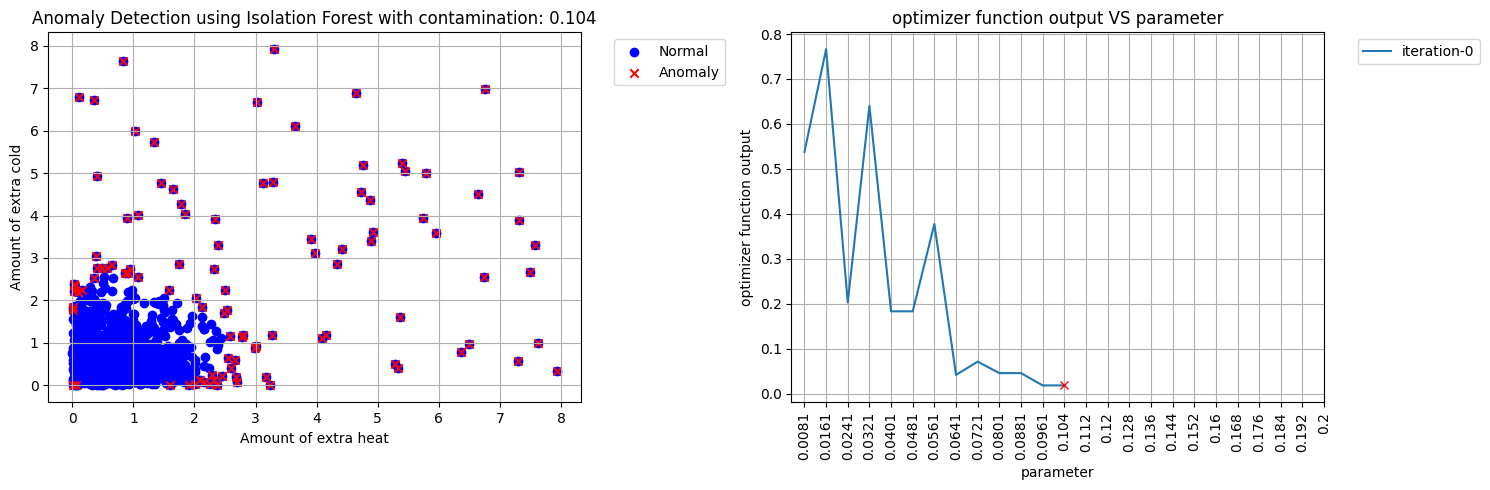

Contaminantion:  0.11204400000000003


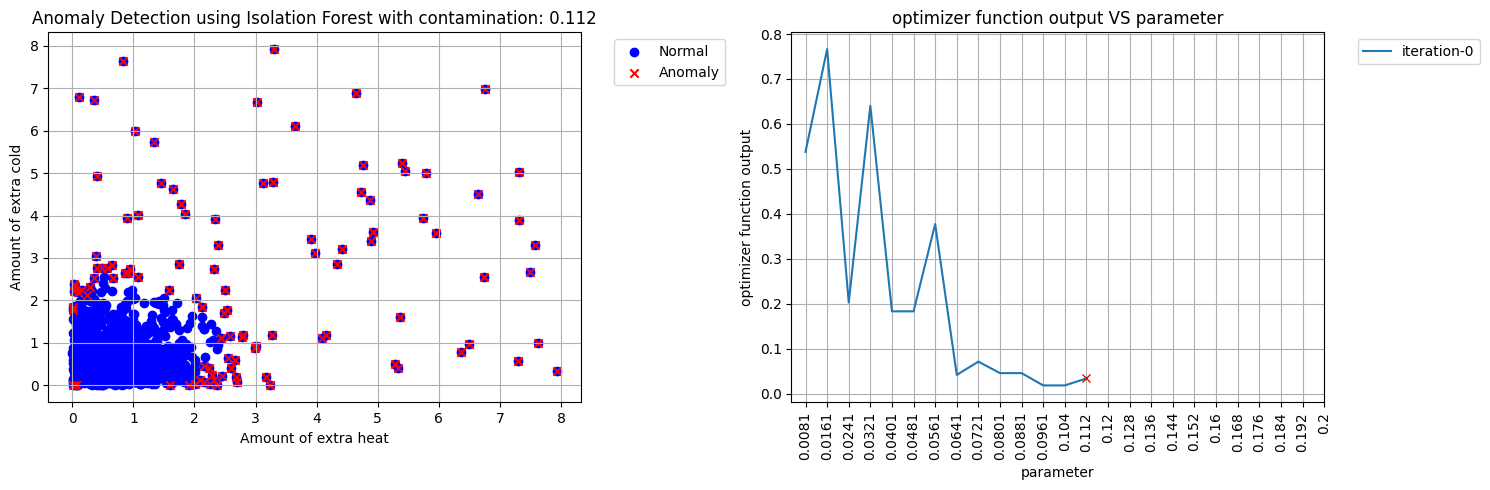

Contaminantion:  0.12004000000000004


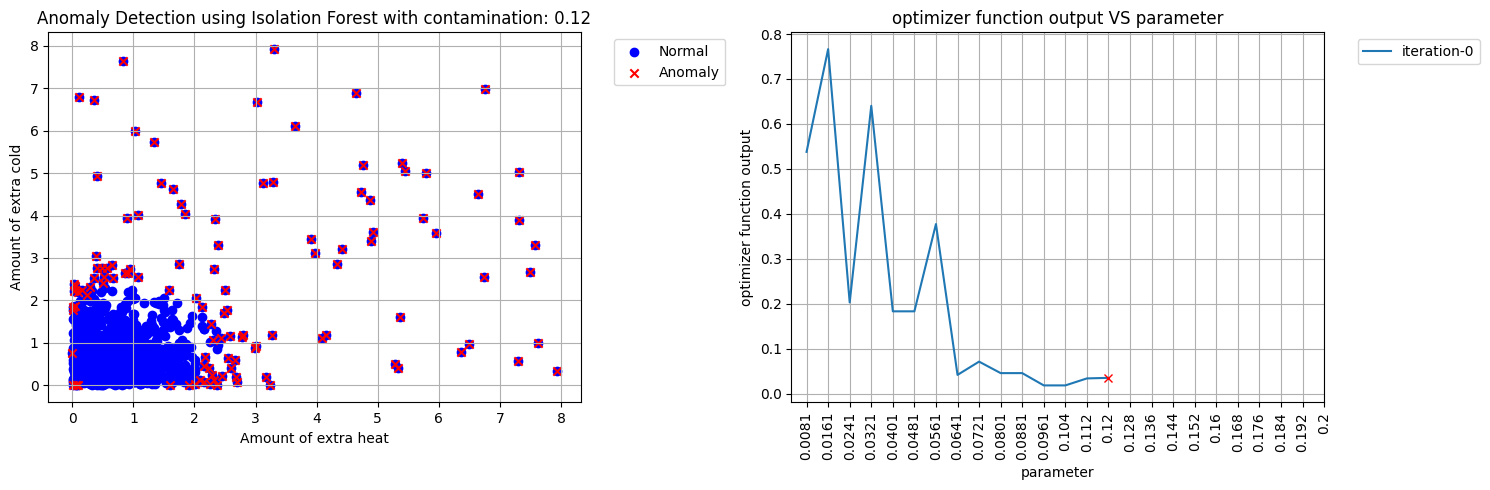

Contaminantion:  0.12803600000000004


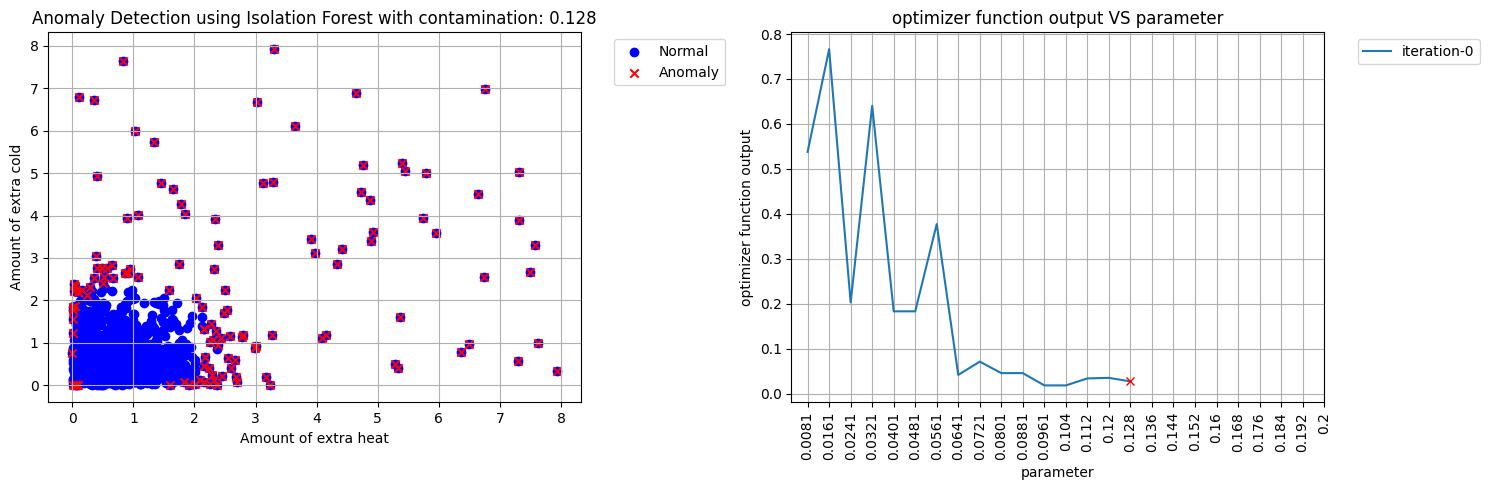

Contaminantion:  0.13603200000000004


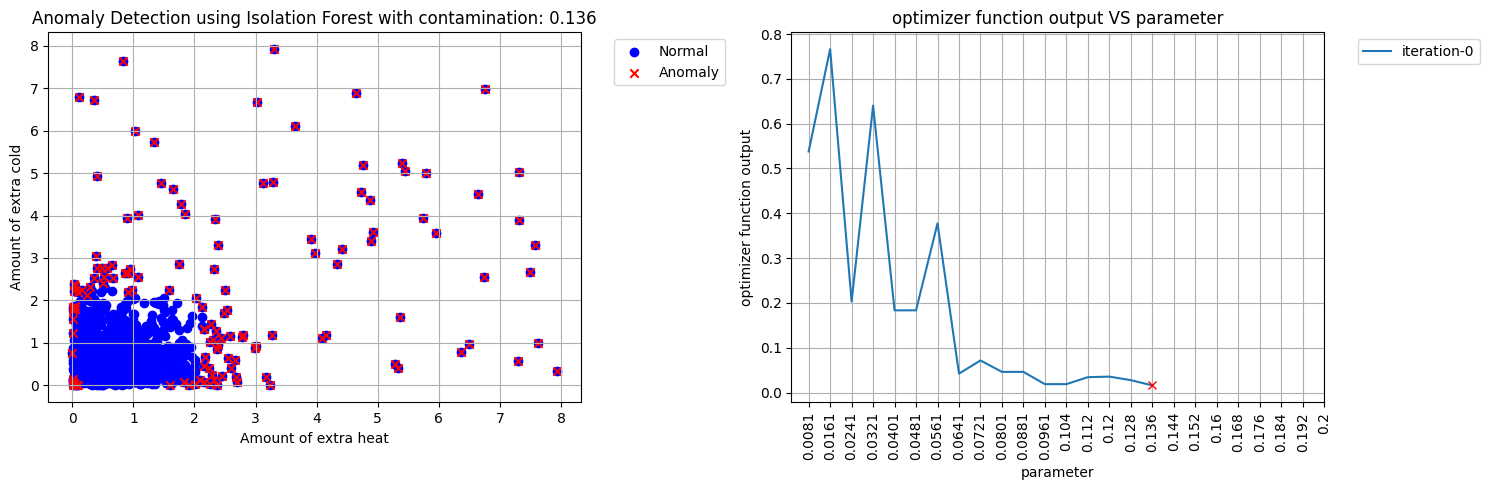

Contaminantion:  0.14402800000000004


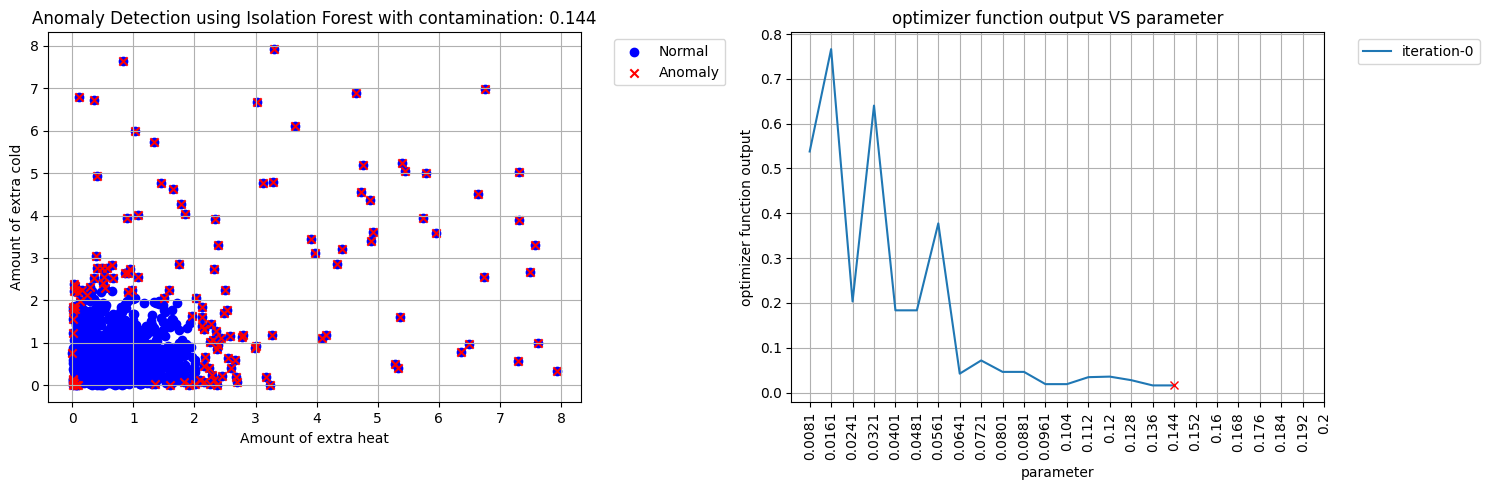

Contaminantion:  0.15202400000000005


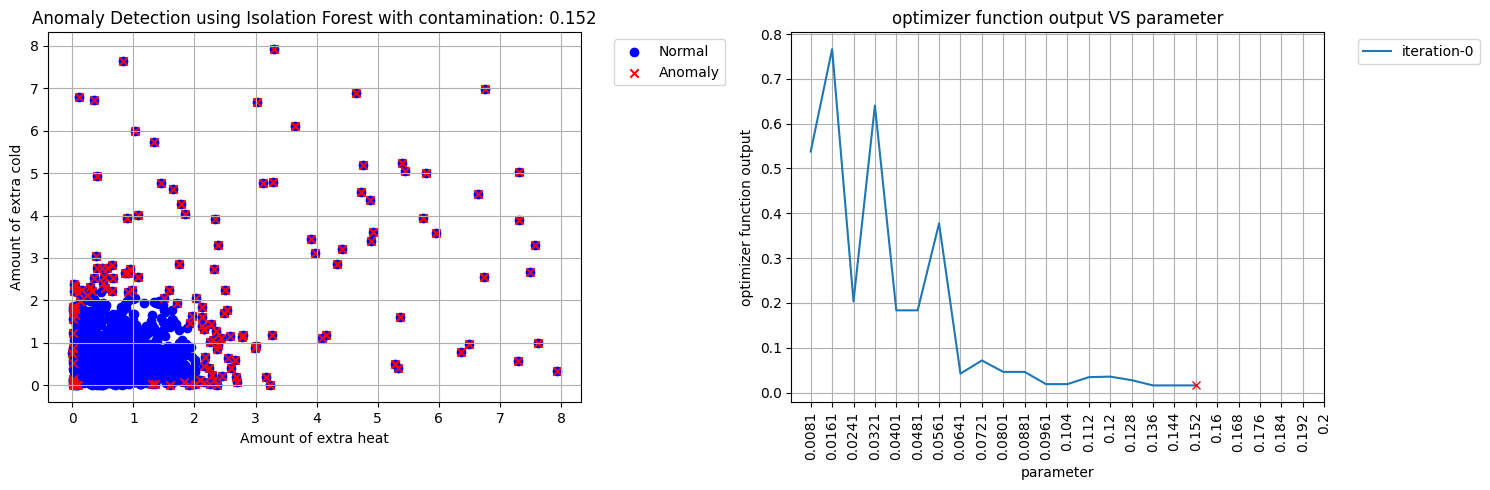

Contaminantion:  0.16002000000000005


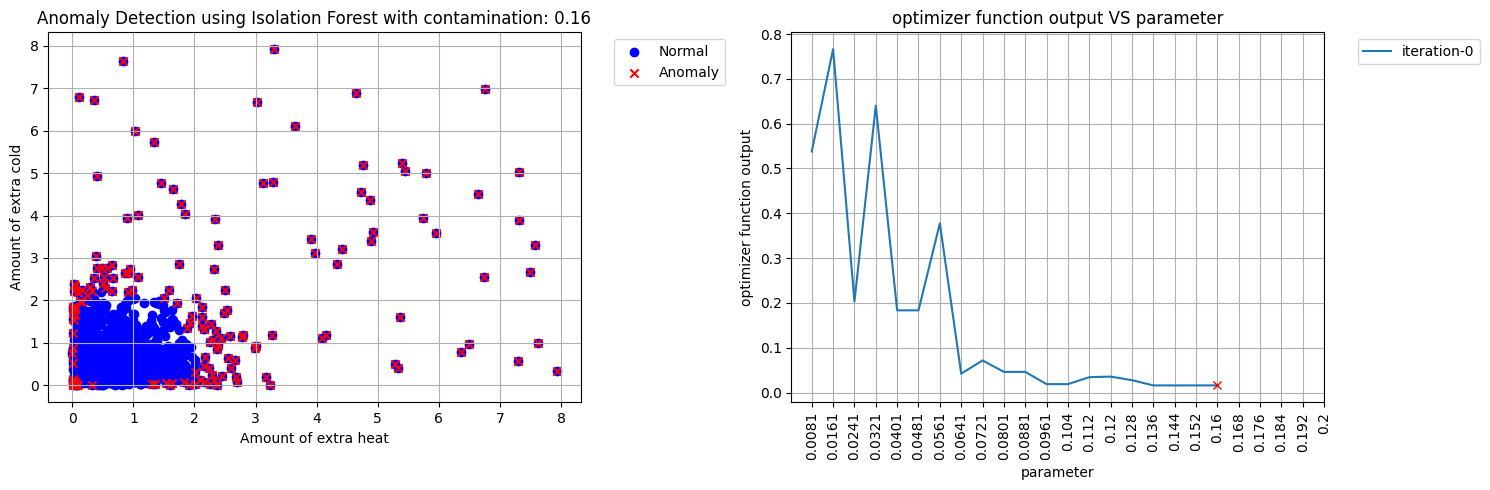

Contaminantion:  0.16801600000000005


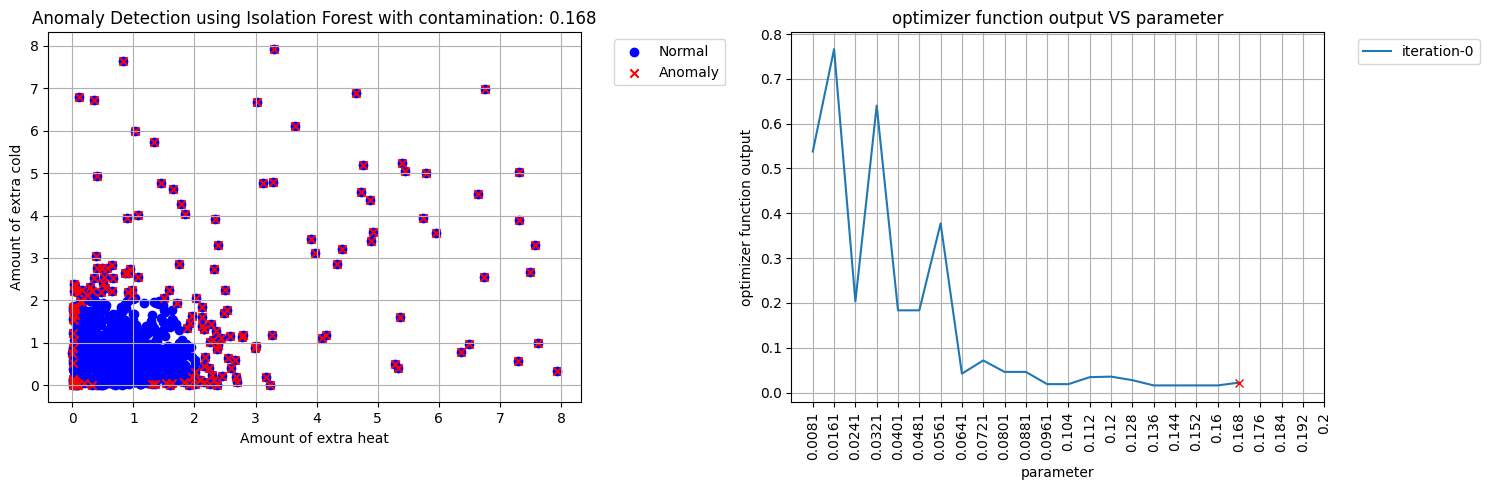

Contaminantion:  0.17601200000000006


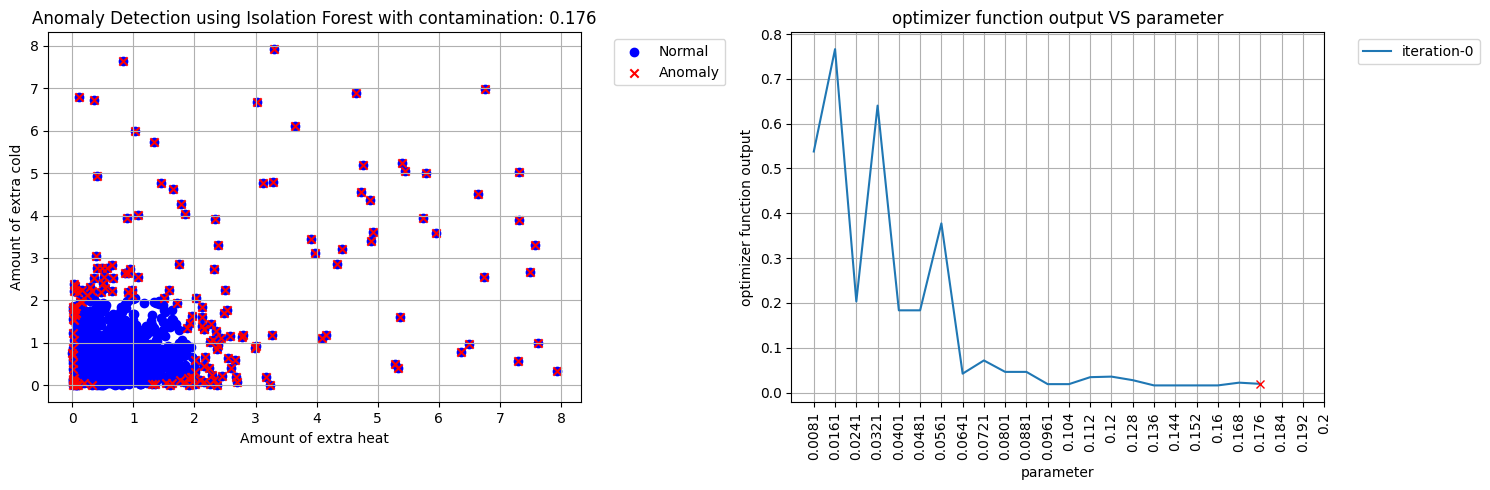

Contaminantion:  0.18400800000000006


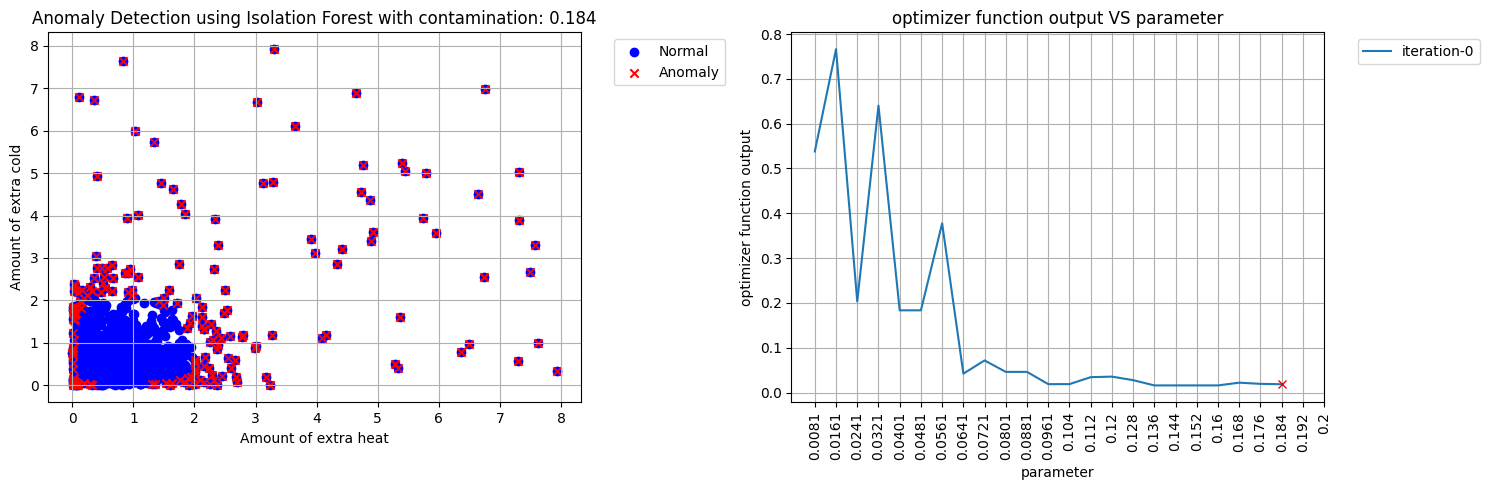

Contaminantion:  0.19200400000000006


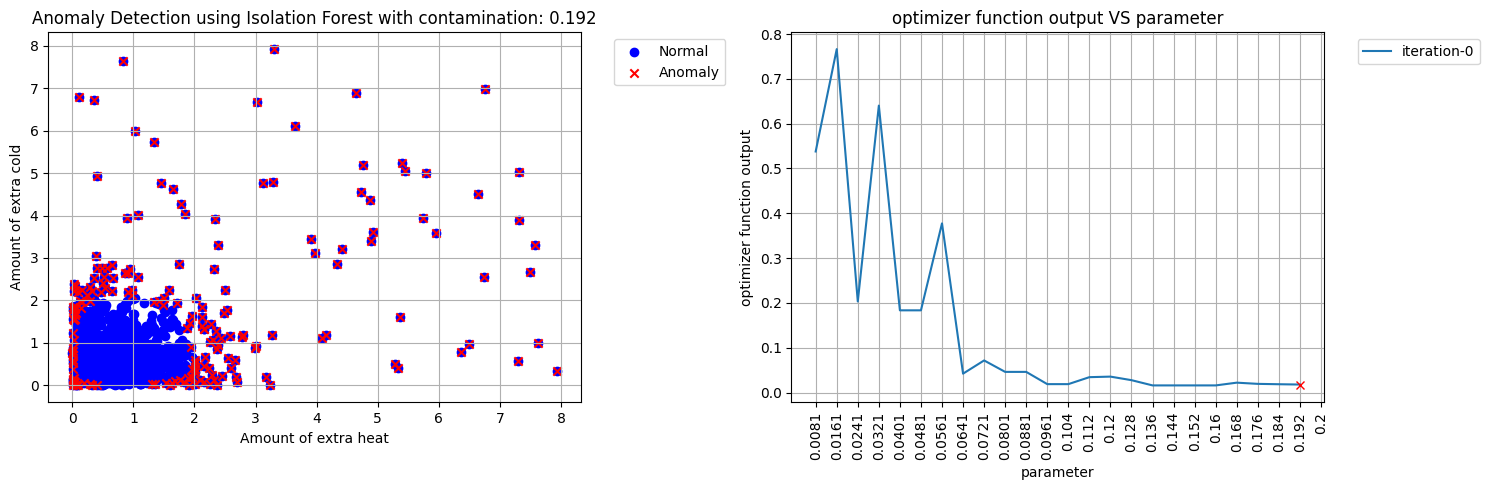

Contaminantion:  0.20000000000000007


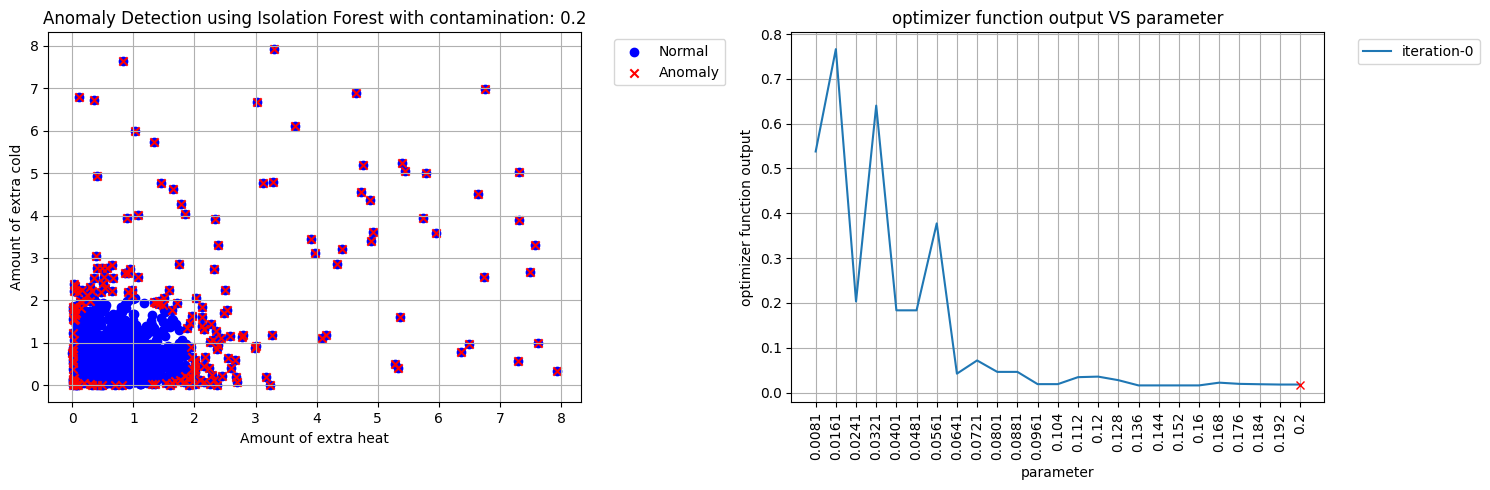

In [48]:
training_logs = {}

# print("The big interval:"+"(",main_start_point,",",main_end_point,")")
# print("step: ",step)
# print("small step",small_step)

random_numbers = [1]
for i, random_number in zip(range(len(random_numbers)),random_numbers):
    range_=[]
    print("random_number: ",random_number)
    start_point=main_start_point
    for _ in range(main_intervals):
        for _ in range(points_in_each_interval):
            #range_.append(random.uniform(start_point,start_point+step))
            range_.append(start_point+small_step)
            start_point=start_point+small_step

    range_.sort()
    neg_range_ = [-i for i in range_]
 
    separation_distances=[]
    for parameter in range_:
        model = IsolationForest(contamination=parameter,max_features=df.shape[1],max_samples=0.8, random_state=random_number)
        model.fit(df.values)
        outliers = model.predict(df.values)
        anomaly_indices = np.where(outliers == -1)[0]
        print("Contaminantion: ",parameter)
        fig, axs = plt.subplots(1,2,figsize=(15,5))
        #plt.figure(figsize=(8, 6))
        axs[0].scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
        axs[0].scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
        axs[0].set_title('Anomaly Detection using Isolation Forest with contamination: {}'.format(round(parameter,4)))
        axs[0].set_xlabel('{}'.format(Feature1))
        axs[0].set_ylabel('{}'.format(Feature2))
        axs[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        axs[0].grid(True)

        df_anomaly = df.iloc[anomaly_indices]
        df_nonanomaly = df.drop(anomaly_indices)
        separation_distance = calculate_separation_distances(df_to_fit=df_nonanomaly, df_to_calculate=df_anomaly)
        separation_distances.append(separation_distance)
        separation_distances = [item for item in separation_distances if item!=None]
        separation_distances = separation_distances + [None]*(len(range_)-len(separation_distances))

        axs[1].plot(range_,separation_distances,label="iteration-{}".format(i))
        axs[1].plot(parameter,separation_distance,color='red',marker='x')
        axs[1].set_xlabel("parameter")
        axs[1].set_ylabel("optimizer function output")
        axs[1].set_title("optimizer function output VS parameter")
        axs[1].set_xticks(range_)
        axs[1].set_xticklabels([round(num,4) for num in range_], rotation='vertical')
        axs[1].grid()
        axs[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        
        plt.tight_layout()
        plt.show()

    training_logs.update({"{}".format(i):
                    {
                    'range_':range_,
                    'neg_range_': neg_range_,
                    'scores': separation_distances                   
                    }})

## Dump training logs

In [49]:
# all in one
with open(training_logs_file, 'w') as f:
    json.dump(training_logs, f)

In [50]:
# Each iteration separately
for i in range(len(random_numbers)):
    range_ = training_logs.get("{}".format(i)).get("range_")
    neg_range = [-i for i in range_]
    scores = training_logs.get("{}".format(i)).get("scores")
    pd.DataFrame({
        'parameter':range_,
        'scores':scores      
        }).to_csv(training_data_path+"/iteration-{}.csv".format(i),index=False)

In [51]:
training_data_path

'd:\\E\\Study\\Projects\\basicml\\data\\training'

## Read training logs

In [52]:
with open(training_logs_file, 'r') as f:
    training_logs = json.load(f)

## Visualize training logs

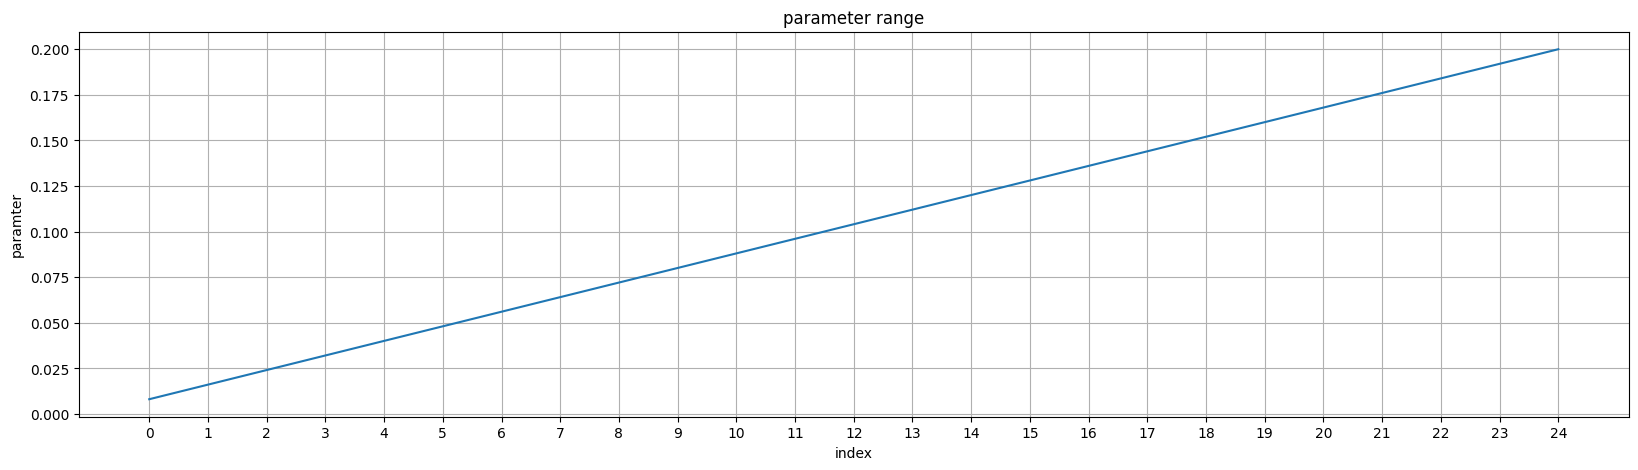

In [53]:
for i in range(len(random_numbers)):
    range_ = training_logs.get("{}".format(i)).get("range_")
    neg_range = [-i for i in range_]
    avg_anomaly_scores = training_logs.get("{}".format(i)).get("avg_anomaly_scores")
    plt.figure(figsize=(20,5))
    plt.plot(range(len(range_)),range_)
    plt.xlabel("index")
    plt.ylabel("paramter")
    plt.title("parameter range")
    plt.xticks(range(len(range_)))
    plt.grid()
    plt.savefig(plots_path+"/training-parameter_generation.png")
    plt.show()
    plt.close()


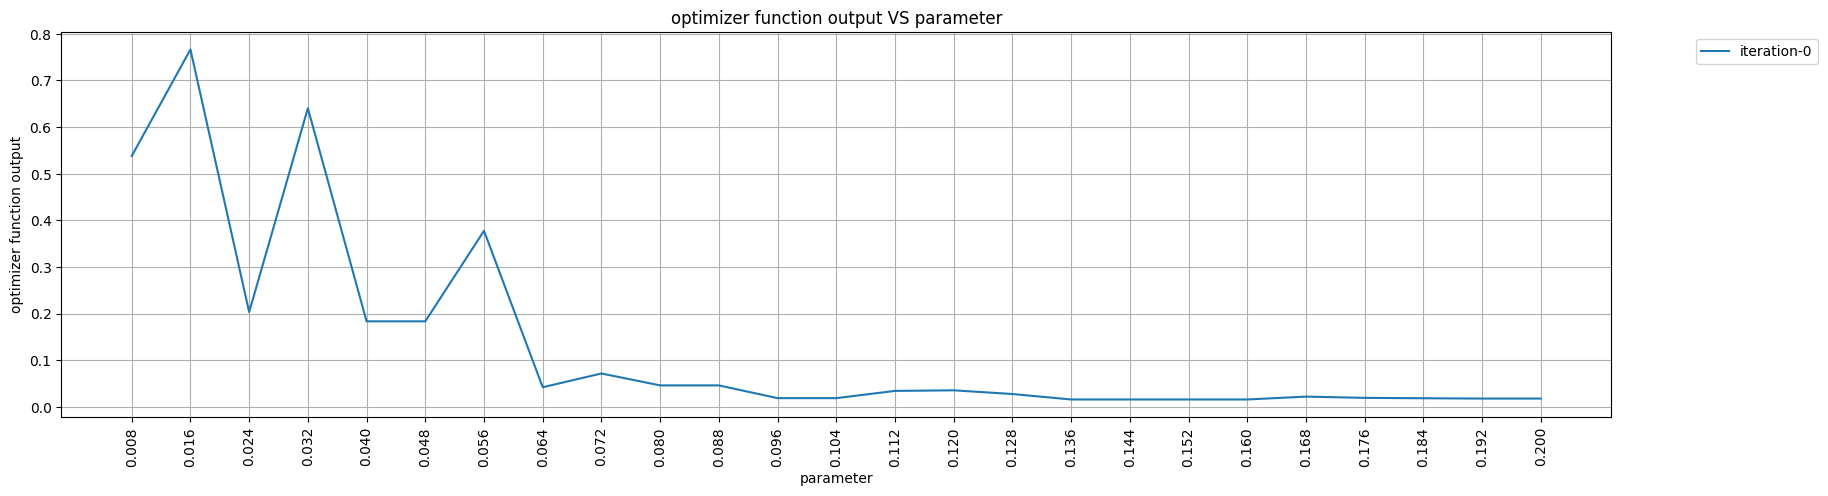

In [54]:
# Look for a sudden drop, a knee. Choose the point at the edge of the sudden drop

for i in range(len(random_numbers)):
    range_ = training_logs.get("{}".format(i)).get("range_")
    scores = training_logs.get("{}".format(i)).get("scores")
    plt.figure(figsize=(20,5))
    plt.plot(range_,scores,label="iteration-{}".format(i))
    plt.xlabel("parameter")
    plt.ylabel("optimizer function output")
    plt.title("optimizer function output VS parameter")
    plt.xticks(range_, rotation='vertical')
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.savefig(plots_path+"/training-parameter_and_output-iteration-{}.png".format(i))
    plt.show()
    plt.close()

## Get the best parameter

In [55]:
knee_points=[]
for i in range(len(random_numbers)):
    range_ = training_logs.get("{}".format(i)).get("range_")
    scores = training_logs.get("{}".format(i)).get("scores")
    knee_locator = KneeLocator(range_, scores, curve='convex', direction='decreasing')
    knee_point = knee_locator.knee
    knee_point = None if knee_point==None else knee_point
    knee_points.append(knee_point)

In [56]:
print(knee_points)
while None in knee_points:
    knee_points.remove(None)
print(knee_points)
final_optimized_parameter = np.mean(knee_points)
print(final_optimized_parameter)

[0.008095999999999999]
[0.008095999999999999]
0.008095999999999999


In [57]:
print("The final_optimized_parameter chosen by algorithm: ",final_optimized_parameter)
print("Please note that there is no guarantee that the above value is the best.")
print("Please view plots and training logs to select the best value for the parameter")
final_optimized_parameter = input("Please enter the parameter value for the final ML model: ")
final_optimized_parameter = float(final_optimized_parameter)
print("You have selected: ",final_optimized_parameter)

The final_optimized_parameter chosen by algorithm:  0.008095999999999999
Please note that there is no guarantee that the above value is the best.
Please view plots and training logs to select the best value for the parameter
You have selected:  0.0561


## Final ML model

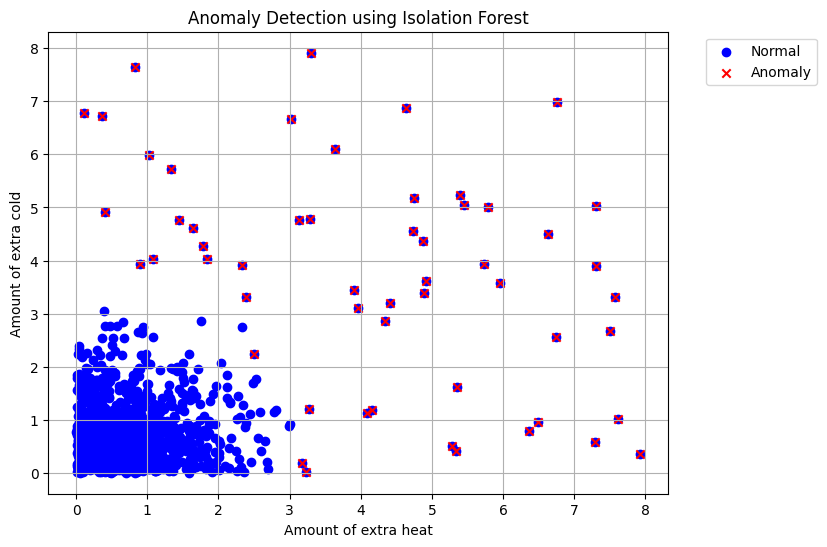

In [58]:
# Create and fit the Isolation Forest model
model = IsolationForest(contamination=final_optimized_parameter,max_features=df.shape[1],max_samples=0.8, random_state=random_number)
model.fit(df.values)

# Predict outliers/anomalies
outliers = model.predict(df.values)

# Anomalies will be labeled as -1, normal points as 1
anomaly_indices = np.where(outliers == -1)[0]

# Visualize the data with anomalies highlighted
plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
plt.scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('{}'.format(Feature1))
plt.ylabel('{}'.format(Feature2))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

## Apply on the whole dataset

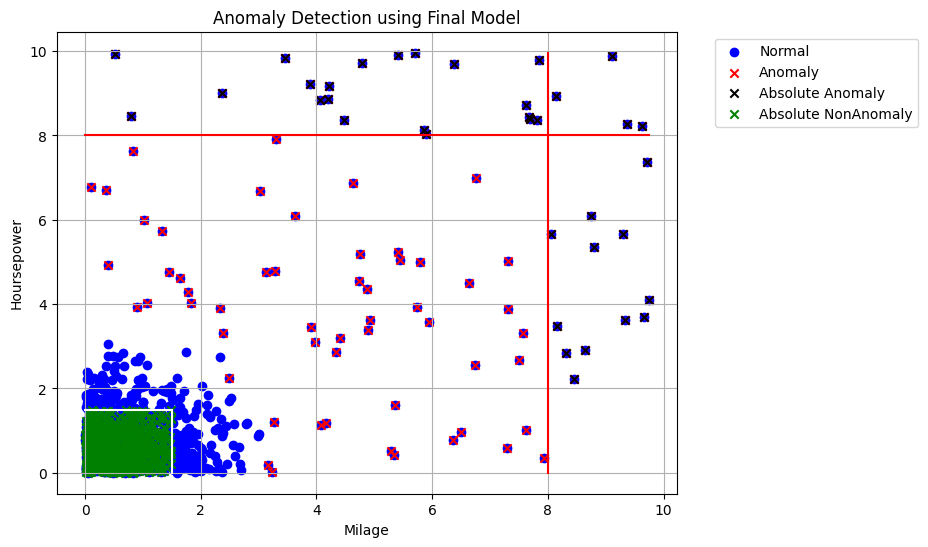

In [63]:
df_to_predict = df_with_business_results.loc[:,['column1','column2']]

# Predict outliers/anomalies
outliers = model.predict(df_with_business_results.loc[:,['column1','column2']].values)

# Anomalies will be labeled as -1, normal points as 1
anomaly_indices = np.where(outliers == -1)[0]
abs_anomaly_indices = np.where(df_with_business_results['business_rule_anomaly'] == -1)[0]
abs_nonanomaly_indices = np.where(df_with_business_results['business_rule_nonanomaly'] == -1)[0]

# Visualize the data with anomalies highlighted
plt.figure(figsize=(8, 6))
plt.scatter(df_with_business_results.iloc[:, 0],df_with_business_results.iloc[:, 1], c='b', marker='o', label='Normal')
plt.scatter(df_with_business_results.iloc[anomaly_indices, 0], df_with_business_results.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')

feature1_max=df_to_predict['column1'].max()
feature1_min=df_to_predict['column1'].min()
feature2_max=df_to_predict['column2'].max()
feature2_min=df_to_predict['column2'].min()

feature1_anomaly_bounds=[0,8]
feature2_anomaly_bounds=[0,8]
feature1_nonanomaly_bounds=[0,1.5]
feature2_nonanomaly_bounds=[0,1.5]

# plot absolute anomalies
plt.scatter(df_to_predict.iloc[abs_anomaly_indices, 0], df_to_predict.iloc[abs_anomaly_indices, 1], color='black', marker='x', label='Absolute Anomaly')
# plot absolute nonanomalies
plt.scatter(df_to_predict.iloc[abs_nonanomaly_indices, 0], df_to_predict.iloc[abs_nonanomaly_indices, 1], c='g', marker='x', label='Absolute NonAnomaly')

# plot anomaly bounds
plt.plot([feature1_min,feature1_max],[feature2_anomaly_bounds[1],feature2_anomaly_bounds[1]],color='red')
plt.plot([feature1_anomaly_bounds[1],feature1_anomaly_bounds[1]],[feature2_min,feature2_max],color='red')

# plot nonanomaly bounds
plt.plot([feature1_nonanomaly_bounds[1],feature1_nonanomaly_bounds[1]],[feature1_min,feature2_nonanomaly_bounds[1]],color='white')
plt.plot([feature2_min,feature1_nonanomaly_bounds[1]],[feature2_nonanomaly_bounds[1],feature2_nonanomaly_bounds[1]],color='white')

plt.title('Anomaly Detection using Final Model')
plt.xlabel('{}'.format(Feature1))
plt.ylabel('{}'.format(Feature2))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

## Save model

In [31]:
import pickle

with open(pickle_model, 'wb') as f:
    pickle.dump(model, f)

## Inference

In [ ]:
# load model
import pickle

with open(pickle_model, 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
#inference
given_point = [10,5]

given_point = [np.array(given_point)]
"anomaly" if loaded_model.predict(given_point)[0]<0 else "non anomaly"